In [ ]:
!pip install nlpaug

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.5/410.5 kB 7.8 MB/s eta 0:00:00


In [89]:
import transformers
import torch

has_gpu = torch.cuda.is_available()
has_mps = torch.backends.mps.is_built()
DEVICE = "cuda"
RANDOM_STATE = 42
MAX_LEN = 256
TRAIN_BATCH_SIZE = 32
VALID_BATCH_SIZE = 16
TEST_BATCH_SIZE = 32
EPOCHS = 2
BERT_PATH = "bert-base-uncased"
MODEL_PATH = "models/model.pt"
TRAINING_FILE = "/content/drive/MyDrive/YelpDataset/yelp_review_train.csv"
TEST_FILE = "/content/drive/MyDrive/YelpDataset/yelp_review_test.csv"
PREPROCESSED_DATA_PATH = "dataset/preprocessed_yelp_review.csv"
BALANCED_DATASET_PATH = "/content/drive/MyDrive/YelpDataset/new_balanced_yelp_review.csv"
BERT_TOKENIZER = transformers.BertTokenizer.from_pretrained(BERT_PATH, do_lower_case=True)
ROBERTA_TOKENIZER =  transformers.RobertaTokenizer.from_pretrained('roberta-base')
STOP_WORDS_DOWNLOAD_PATH = "dataset/"
LEARNING_RATE = 3e-5
FINE_TUNING_LEARNING_RATE = 3e-6

# a) \& b) Dataset Preprocessing and Input Preprocessing

In [63]:
import os
import torch
import nltk
import regex as re
import pandas as pd
import nlpaug.augmenter.word as naw
import warnings

from sklearn.preprocessing import LabelEncoder
from nltk.corpus import stopwords
from tqdm import tqdm

def save_preprocessed_data(data, filepath):
    # Function to save preprocessed data to a CSV file
    # data: DataFrame containing preprocessed data
    # filepath: Location where the CSV file will be saved
    data.to_csv(filepath, index=False)

def load_preprocessed_data(filepath):
    # Function to load preprocessed data from a CSV file
    # filepath: Location of the CSV file to be loaded
    return pd.read_csv(filepath)

class BERTDataset:
    # A custom dataset class for BERT model
    def __init__(self, review, target):
        # Constructor for the BERTDataset class
        # review: List or series of review texts
        # target: List or series of target labels
        self.review = review
        self.target = target
        self.tokenizer = BERT_TOKENIZER  # Tokenizer specific to BERT
        self.max_len = MAX_LEN  # Maximum sequence length

    def __len__(self):
        # Returns the length of the dataset
        return len(self.review)

    def __getitem__(self, item):
        # Method to get the ith item from the dataset
        review = str(self.review[item])
        review = " ".join(review.split())  # Clean and split the review text

        # Tokenize the review
        inputs = self.tokenizer.encode_plus(
            review,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            truncation=True
        )

        # Extract tokens, attention masks, and token type IDs from tokenizer output
        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]
        token_type_ids = inputs["token_type_ids"]
        target = self.target[item]

        # Return a dictionary of tensors for model input
        return {
            "ids": torch.tensor(ids, dtype=torch.long),
            "mask": torch.tensor(mask, dtype=torch.long),
            "token_type_ids": torch.tensor(token_type_ids, dtype=torch.long),
            "targets": torch.tensor(target, dtype=torch.long),
        }
        
class RoBERTaDataset:
    # A custom dataset class for RoBERTa model
    def __init__(self, review, target):
        # Constructor for the RoBERTaDataset class
        # review: List or series of review texts
        # target: List or series of target labels
        self.review = review
        self.target = target
        self.tokenizer = ROBERTA_TOKENIZER  # Tokenizer specific to RoBERTa
        self.max_len = MAX_LEN  # Maximum sequence length

    def __len__(self):
        # Returns the length of the dataset
        return len(self.review)

    def __getitem__(self, item):
        # Method to get the ith item from the dataset
        review = str(self.review[item])
        review = " ".join(review.split())  # Clean and split the review text

        # Tokenize the review
        inputs = self.tokenizer.encode_plus(
            review,
            None,
            add_special_tokens=True,
            max_length=self.max_len,
            pad_to_max_length=True,
            truncation=True
        )

        # Extract tokens and attention masks from tokenizer output
        # Note: RoBERTa does not use token type IDs
        ids = inputs["input_ids"]
        mask = inputs["attention_mask"]
        target = self.target[item]

        # Return a dictionary of tensors for model input
        return {
            "ids": torch.tensor(ids, dtype=torch.long),
            "mask": torch.tensor(mask, dtype=torch.long),
            "targets": torch.tensor(target, dtype=torch.long),
        }

class DatasetPreprocessor:
    def __init__(self, dataset_df,text_col="text",label_col="stars"):
        self.dataset_df = dataset_df
        self.text_col = text_col
        self.label_col = label_col
        tqdm.pandas()

    def remove_punctuation(self, text: str) -> str:
        """
        Remove punctuation from the given text.

        Args:
        text (str): The text to be processed.

        Returns:
        str: The text with punctuation removed.
        """
        return re.sub(r'[^\w\s]', '', text)

    def convert_to_lowercase(self, text: str) -> str:
        """
        Convert all characters in the given text to lowercase.

        Args:
        text (str): The text to be processed.

        Returns:
        str: The text in lowercase.
        """
        return text.lower()

    def download_stopwords(self, download_dir):
        # Define the path where NLTK will store the stopwords
        nltk.data.path.append(download_dir)

        # Check if the stopwords are already downloaded
        if not os.path.exists(os.path.join(download_dir, "corpora/stopwords")):
            # Download stopwords
            nltk.download("stopwords", download_dir=download_dir)
        else:
            print("Stopwords already downloaded.")

    def remove_stopwords(self, text: str, stopwords: set) -> str:
        """
        Remove stopwords from the given text.

        Args:
        text (str): The text to be processed.
        stopwords (set): A set of stopwords to remove from the text.

        Returns:
        str: The text with stopwords removed.
        """
        return ' '.join([word for word in text.split() if word not in stopwords])

    def categorize_stars(self, stars: float) -> str:
        """
        Categorize the star rating into Positive, Negative, and Neutral.

        Args:
        stars (float): The star rating.

        Returns:
        str: The category of the rating (Positive, Negative, Neutral).
        """
        if stars > 3:
            return "Positive"
        elif stars == 3:
            return "Neutral"
        else:
            return "Negative"

    def augment_data_roberta(self,data, class_name, target_size=20000, model_path='roberta-base'):
        aug = naw.ContextualWordEmbsAug(model_path=model_path, action="insert")
        augmented_texts = []

        while len(augmented_texts) + len(data) < target_size:
            for text in tqdm(data['review'], desc="Augmenting Data"):
                augmented_text = aug.augment(text)
                augmented_texts.append({'review': augmented_text, 'sentiment': class_name})
                if len(augmented_texts) + len(data) >= target_size:
                    break

        return pd.DataFrame(augmented_texts)

    def preprocess_dataset(self):

        print("Preprocessing Dataset...")
        print("1. Removing punctuations")
        #Apply remove_punctuation function to the text column
        self.dataset_df['text_no_punctuation'] = self.dataset_df['text'].progress_apply(self.remove_punctuation)

        print("2. Converting text to lower case")
        # Apply the convert_to_lowercase function to the text_no_punctuation column
        self.dataset_df['text_lowercase'] = self.dataset_df['text_no_punctuation'].progress_apply(self.convert_to_lowercase)

        # Downlaod stop words in English Language
        print("3. Removing Stop Words")

        self.download_stopwords(STOP_WORDS_DOWNLOAD_PATH)

        english_stopwords = stopwords.words('english')

        self.dataset_df['text_no_stopwords'] = self.dataset_df['text_lowercase'].progress_apply(lambda x: self.remove_stopwords(x, english_stopwords))

        print("4. Converting to stars to sentiment")
        # Apply the categorize_stars function to the stars column
        self.dataset_df['sentiment_category'] = self.dataset_df['stars'].progress_apply(self.categorize_stars)

        # Creating a dataframe with only the necessary columns for analysis
        final_preprocessed_data = self.dataset_df[['text_no_stopwords', 'sentiment_category']]

        # Renaming the columns for clarity
        final_preprocessed_data.columns = ['review', 'sentiment']

        # Initializing the label encoder
        label_encoder = LabelEncoder()

        print("5. Enconding sentiments to 0, 1, 2 (Positive, Negative, Neutral)")
        # Applying label encoding to the sentiment column
        final_preprocessed_data['sentiment'] = label_encoder.fit_transform(final_preprocessed_data['sentiment'])

        # Display the mapping of categories to integers and the first few rows of the dataset
        category_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

        # Finalizing the preprocessed DataFrame with only the necessary columns for model training
        preprocessed_data = final_preprocessed_data[['review', 'sentiment']]
        print("Preprocessing done!")
        return preprocessed_data


In [123]:
train_dataset = pd.read_csv(TRAINING_FILE)
preprocessor = DatasetPreprocessor(train_dataset)
preprocessed_dataset = preprocessor.preprocess_dataset()
preprocessed_dataset.head()

Preprocessing Dataset...
1. Removing punctuations


100%|██████████| 174757/174757 [00:03<00:00, 44666.50it/s]


2. Converting text to lower case


100%|██████████| 174757/174757 [00:00<00:00, 658010.88it/s]


3. Removing Stop Words
Stopwords already downloaded.


100%|██████████| 174757/174757 [00:30<00:00, 5697.97it/s]


4. Converting to stars to sentiment


100%|██████████| 174757/174757 [00:00<00:00, 1132633.83it/s]


5. Enconding sentiments to 0, 1, 2 (Positive, Negative, Neutral)
Preprocessing done!


,review,sentiment
0,went lunch found burger meh obvious focus burg...,0
1,needed new tires wifes car special order next ...,2
2,jim woltman works goleta honda 5 stars knowled...,2
3,times get shrimp theyve got nice selection dif...,2
4,one fantastic place eat whether hungry need go...,2


# Unbalanced Training Dataset Distribution

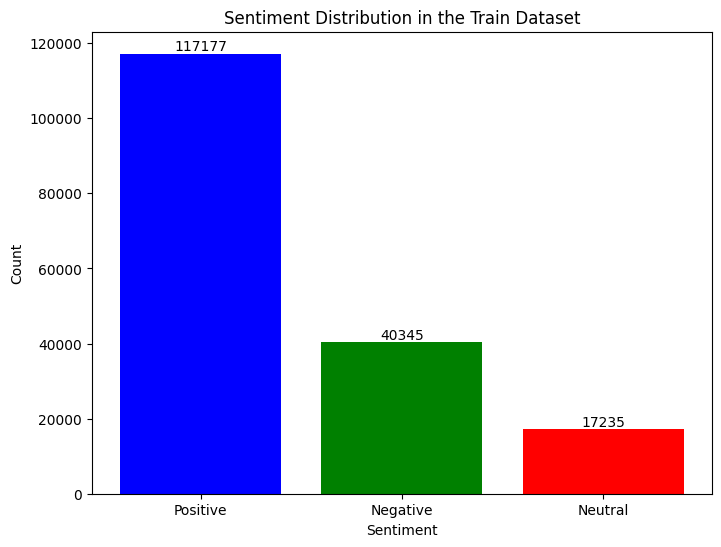

In [128]:
import matplotlib.pyplot as plt
# Plotting the bar graph
label_counts = preprocessed_dataset["sentiment"].value_counts()
labels = ["Positive","Negative","Neutral"]
plt.figure(figsize=(8, 6))
bars = plt.bar(labels,label_counts, color=['blue', 'green', 'red'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution in the Train Dataset')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

plt.show()

# Balanced Training Data Class Distribution

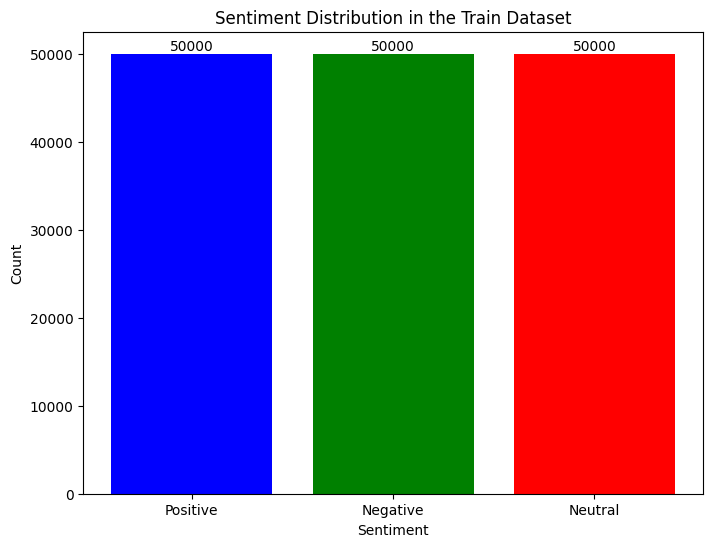

In [129]:
# Augmented Dataset
balanced_preprocessed_dataset = pd.read_csv(BALANCED_DATASET_PATH)
# Plotting the bar graph
label_counts = balanced_preprocessed_dataset["sentiment"].value_counts()
labels = ["Positive","Negative","Neutral"]
plt.figure(figsize=(8, 6))
bars = plt.bar(labels,label_counts, color=['blue', 'green', 'red'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution in the Train Dataset')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

plt.show()

# Test Dataset Class Distribution

In [155]:
test_dataset = pd.read_csv(TEST_FILE)
preprocessor = DatasetPreprocessor(test_dataset)
preprocessed_dataset = preprocessor.preprocess_dataset()
preprocessed_dataset.head()

Preprocessing Dataset...
1. Removing punctuations


100%|██████████| 13980/13980 [00:00<00:00, 46811.91it/s]


2. Converting text to lower case


100%|██████████| 13980/13980 [00:00<00:00, 616368.52it/s]


3. Removing Stop Words
Stopwords already downloaded.


100%|██████████| 13980/13980 [00:02<00:00, 5854.63it/s]


4. Converting to stars to sentiment


100%|██████████| 13980/13980 [00:00<00:00, 950932.02it/s]

5. Enconding sentiments to 0, 1, 2 (Positive, Negative, Neutral)
Preprocessing done!


,review,sentiment
0,hidden treasure awesome service delicious food...,2
1,family patients since 5 years old 34 trust qua...,2
2,rarely get pedicures blue nails practice combi...,2
3,came large group may items missing menu lobste...,0
4,view great morgans pier bartenders even good s...,0


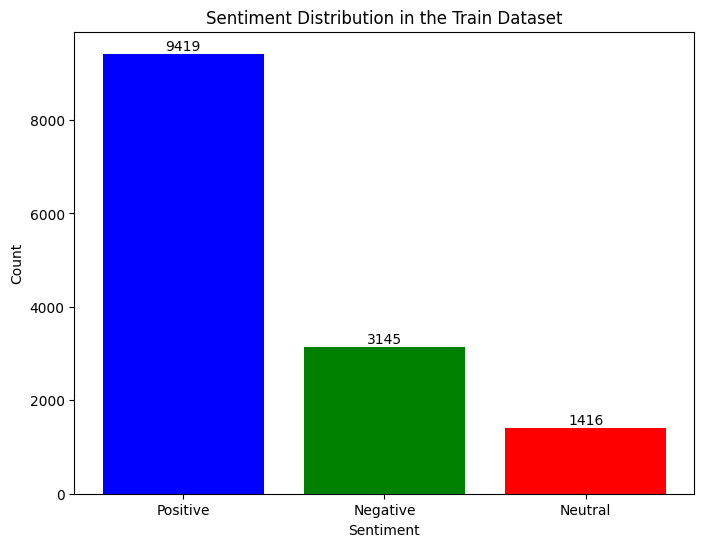

In [156]:
import matplotlib.pyplot as plt
# Plotting the bar graph
label_counts = preprocessed_dataset["sentiment"].value_counts()
labels = ["Positive","Negative","Neutral"]
plt.figure(figsize=(8, 6))
bars = plt.bar(labels,label_counts, color=['blue', 'green', 'red'])
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.title('Sentiment Distribution in the Train Dataset')
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')

plt.show()

## Custom Loss Function

In [67]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=1, gamma=2, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        CE_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-CE_loss)  # Prevents nans when probability 0
        F_loss = self.alpha * (1 - pt)**self.gamma * CE_loss

        if self.reduction == 'mean':
            return torch.mean(F_loss)
        elif self.reduction == 'sum':
            return torch.sum(F_loss)
        else:
            return F_loss

## c) Transformer Implementation

In [113]:
import transformers
import torch.nn as nn
import torch
import torch.nn as nn
import numpy as np

from tqdm import tqdm
from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score
from torch.utils.data import DataLoader
from collections import Counter


class BERTBaseUncasedClfHead(nn.Module):
    def __init__(self):
        super(BERTBaseUncasedClfHead, self).__init__()
        self.bert = transformers.BertModel.from_pretrained(BERT_PATH)
        # New dense layer
        self.dense = nn.Linear(768, 512)

        # Layer normalization
        self.layer_norm = nn.LayerNorm(512)

        # Dropout for the new dense layer
        self.dropout = nn.Dropout(0.3)

        # Output layer remains the same
        self.out = nn.Linear(512, 3)

    def freeze_base_model(self):
        # Freeze all parameters in the BERT model
        for param in self.bert.parameters():
            param.requires_grad = False


    def forward(self, ids, mask, token_type_ids):
        _, pooled_output = self.bert(ids, attention_mask=mask, token_type_ids=token_type_ids, return_dict=False)

        # Passing through the new dense layer
        x = self.dense(pooled_output)

        # Applying layer normalization
        x = self.layer_norm(x)

        # Applying dropout
        x = self.dropout(x)

        # Final output layer
        output = self.out(x)
        return output

class RobertaGRUClassifier(nn.Module):
    def __init__(self):
        super(RobertaGRUClassifier, self).__init__()
        # RoBERTa model
        self.roberta = transformers.RobertaModel.from_pretrained('roberta-base')

        # GRU layer
        self.gru = nn.GRU(input_size=768, hidden_size=256, num_layers=1, batch_first=True)

        # Batch Normalization
        self.batch_norm = nn.BatchNorm1d(256)

        # Dropout
        self.dropout = nn.Dropout(0.3)

        # Flatten Layer
        self.flatten = nn.Flatten()

        # Dense layers
        self.dense1 = nn.Linear(256, 128)
        self.dense2 = nn.Linear(128, 3)  # Assuming 3 classes for classification

    def freeze_base_model(self):
        # Freeze all parameters in the BERT model
        for param in self.roberta.parameters():
            param.requires_grad = False

    def unfreeze_layers(self, last_n_layers):
        # Freeze all layers first
        for param in self.roberta.parameters():
            param.requires_grad = False

        # Unfreeze the last `last_n_layers`
        for layer in self.roberta.encoder.layer[-last_n_layers:]:
            for param in layer.parameters():
                param.requires_grad = True

    def forward(self, input_ids, attention_mask):
        # RoBERTa outputs
        roberta_output = self.roberta(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = roberta_output.last_hidden_state

        # GRU
        gru_output, _ = self.gru(sequence_output)
        gru_last_output = gru_output[:, -1, :]

        # Apply batch normalization only if batch size > 1
        if gru_last_output.size(0) > 1:
            normalized_output = self.batch_norm(gru_last_output)
        else:
            normalized_output = gru_last_output

        dropout_output = self.dropout(normalized_output)

        # Flatten the output for the dense layer
        flattened_output = self.flatten(dropout_output)

        # Dense layers
        dense_output = torch.relu(self.dense1(flattened_output))
        logits = self.dense2(dense_output)

        return logits

# Training, Validation and Test Loops

In [146]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
from itertools import cycle
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize
class Engine:
    def __init__(self,model,device,labels,model_type):
        self.model = model
        self.device = device
        self.labels = labels
        self.model_type = model_type

    def loss_fn(self, outputs, targets):
        return nn.CrossEntropyLoss()(outputs.view(-1,3), targets.view(-1))

    def focal_loss_fn(self, outputs, targets, alpha=1, gamma=2):
        focal_loss = FocalLoss(alpha=alpha, gamma=gamma, reduction='mean')

        return focal_loss(outputs.view(-1, 3), targets.view(-1))

    def plot_confusion_matrix(self, targets, outputs, class_names):
        # Convert outputs to predicted class indices
        predicted_labels = np.argmax(outputs, axis=1)
        cm = confusion_matrix(targets, predicted_labels)

        plt.figure(figsize=(10, 10))
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Confusion Matrix')
        plt.colorbar()

        tick_marks = np.arange(len(class_names))
        plt.xticks(tick_marks, class_names, rotation=45)
        plt.yticks(tick_marks, class_names)

        # Iterate over the confusion matrix and add labels to each cell
        for i, j in np.ndindex(cm.shape):
            plt.text(j, i, cm[i, j], horizontalalignment='center', color='white' if cm[i, j] > cm.max() / 2 else 'black')

        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.show()

    def plot_roc_curve(self,targets, outputs, n_classes):
        # Compute ROC curve and ROC area for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        targets_one_hot = np.eye(n_classes)[targets]  # Convert to one-hot encoding
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(targets_one_hot[:, i], np.array(outputs)[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        # Plot all ROC curves
        plt.figure()
        colors = cycle(['blue', 'red', 'green'])
        for i, color in zip(range(n_classes), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=2,
                    label='ROC curve of class {0} (area = {1:0.2f})'.format(i, roc_auc[i]))
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) - multi-class')
        plt.legend(loc="lower right")
        plt.show()

    def train_fn(self, data_loader_tqdm, optimizer, scheduler):
        self.model.train()
        loss = None

        total_loss = 0
        total_accuracy = 0
        num_batches = 0

        for bi, d in data_loader_tqdm:
            ids = d["ids"].to(self.device, dtype=torch.long)
            mask = d["mask"].to(self.device, dtype=torch.long)
            targets = d["targets"].to(self.device, dtype=torch.long)

            optimizer.zero_grad()

            if self.model_type == "bert":
                token_type_ids = d["token_type_ids"].to(self.device, dtype=torch.long)
                outputs = self.model(ids, mask, token_type_ids)
            else:  # Assuming RoBERTa or similar
                outputs = self.model(ids, mask)

            loss = self.loss_fn(outputs, targets)


            total_loss += loss.item()
            num_batches += 1
            preds = torch.argmax(outputs, dim=1)
            accuracy = accuracy_score(targets.cpu().numpy(), preds.cpu().numpy())
            total_accuracy += accuracy
            # Calculate cumulative average
            cumulative_avg_loss = total_loss / num_batches
            cumulative_avg_accuracy = total_accuracy / num_batches
            # Update tqdm description with cumulative average loss and accuracy
            data_loader_tqdm.set_description(f'Loss: {cumulative_avg_loss:.4f},Accuracy: {cumulative_avg_accuracy:.4f}')

            loss.backward()
            optimizer.step()
            scheduler.step()
        return total_loss / len(data_loader_tqdm), total_accuracy / len(data_loader_tqdm)


    def eval_fn(self,data_loader_tqdm):
        self.model.eval()
        fin_targets = []
        fin_outputs = []
        with torch.no_grad():
            for bi, d in data_loader_tqdm:
                ids = d["ids"].to(self.device, dtype=torch.long)
                mask = d["mask"].to(self.device, dtype=torch.long)
                targets = d["targets"].to(self.device, dtype=torch.long)

                if self.model_type == "bert":
                    token_type_ids = d["token_type_ids"].to(self.device, dtype=torch.long)
                    outputs = self.model(ids, mask, token_type_ids)
                else:  # Assuming RoBERTa or similar
                    outputs = self.model(ids,mask)

                # Convert model outputs to probabilities and then to class indices
                probs = torch.softmax(outputs, dim=1)
                fin_outputs.extend(probs.cpu().detach().numpy().tolist())
                # Add the true labels
                fin_targets.extend(targets.cpu().detach().numpy().tolist())
        return fin_outputs, fin_targets

    def test_eval_fn(self, test_data_loader):
        self.model.eval()
        all_targets = []
        all_probabilities = []
        all_predictions = []
        self.model.to(self.device)
        with torch.no_grad():
            for bi, d in tqdm(enumerate(test_data_loader), total=len(test_data_loader)):
                ids = d["ids"].to(self.device, dtype=torch.long)
                mask = d["mask"].to(self.device, dtype=torch.long)
                targets = d["targets"].to(self.device, dtype=torch.long)
                if self.model_type == "bert":
                    token_type_ids = d["token_type_ids"].to(self.device, dtype=torch.long)
                    outputs = self.model(ids,mask,token_type_ids)
                else:  # Assuming RoBERTa or similar
                    outputs = self.model(ids,mask)
                    _, predicted = torch.max(outputs, 1)
                    probabilities = torch.softmax(outputs, dim=1).cpu().numpy()
                    all_targets.extend(targets.view_as(predicted).cpu().numpy())
                    all_probabilities.extend(probabilities)
                    all_predictions.extend(predicted.cpu().numpy())
        # Calculate F1 Score
        f1 = f1_score(all_targets, all_predictions, average='weighted')
        print(f'F1 Score: {f1}')

        # Calculate and Print Test Accuracy
        test_accuracy = accuracy_score(all_targets, all_predictions)
        print(f'Test Accuracy: {test_accuracy:.2f}')

        # One-hot encode the targets
        num_classes = all_probabilities[0].size
        all_targets_one_hot = label_binarize(all_targets, classes=range(num_classes))

        # Calculate AUC for each class
        auc_scores = {}
        for i in range(num_classes):
            auc_score = roc_auc_score(all_targets_one_hot[:, i], np.array(all_probabilities)[:, i], multi_class='ovr')
            auc_scores[f'Class {i} AUC'] = auc_score

        print("AUC Scores:", auc_scores)
        return all_targets, all_probabilities



## Training 

In [147]:
import torch
import os
import pandas as pd
import torch.nn as nn
import numpy as np
import sys

from sklearn import model_selection
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup

def save_preprocessed_data(data, filepath):
    data.to_csv(filepath, index=False)

def load_preprocessed_data(filepath):
    return pd.read_csv(filepath)

def train(epoch, train_data_loader, engine, training_accuracy, training_loss, optimizer, scheduler):
    # Training loop
    final_loss = 0
    final_accuracy = 0
    with tqdm(enumerate(train_data_loader), total=len(train_data_loader), unit="Batch") as data_loader_tqdm:
        data_loader_tqdm.set_description(f"Epoch {epoch}")
        train_loss, train_accuracy = engine.train_fn(data_loader_tqdm, optimizer, scheduler)
        training_accuracy.append(train_accuracy)
        training_loss.append(train_loss)
    print(f"\nEpoch {epoch+1}/{EPOCHS}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

def evaluate(epoch, valid_data_loader, engine, validation_accuracy,best_accuracy, model):

    with tqdm(enumerate(valid_data_loader), total=len(valid_data_loader)) as data_loader_tqdm:
        outputs, targets = engine.eval_fn(data_loader_tqdm)

    # Convert outputs to numpy arrays and then to class indices
    predicted_labels = np.argmax(outputs, axis=1)
    # Convert targets to numpy arrays
    targets = np.array(targets)

    accuracy = metrics.accuracy_score(targets, predicted_labels)
    validation_accuracy.append(accuracy)
    print(f"Validation - Epoch: {epoch} Accuracy: {100. * accuracy}%")
    if accuracy > best_accuracy:
        model_path = MODEL_PATH
        model_dir = os.path.dirname(model_path)

        if not os.path.exists(model_dir):
            os.makedirs(model_dir)
        torch.save(model.state_dict(), MODEL_PATH)
        best_accuracy = accuracy

def run(model_type):
    warnings.filterwarnings('ignore')

    # Check if preprocessed data exists

    print("Preprocessing data...")
    # raw_data_df = pd.read_csv(TRAINING_FILE)
    # proccessor = DatasetPreprocessor(raw_data_df)
    # dfx = proccessor.preprocess_dataset()
    dfx = load_preprocessed_data(BALANCED_DATASET_PATH)

    df_train, df_valid = model_selection.train_test_split(
        dfx, test_size=0.1, random_state=42, stratify=dfx.sentiment.values
    )

    df_train = df_train.reset_index(drop=True)
    df_valid = df_valid.reset_index(drop=True)

    if model_type.lower() == 'bert':
        train_dataset = BERTDataset(
            review=df_train.review.values, target=df_train.sentiment.values
        )
        valid_dataset = BERTDataset(
            review=df_valid.review.values, target=df_valid.sentiment.values
        )

    elif model_type.lower() == 'roberta':
        train_dataset = RoBERTaDataset(
            review=df_train.review.values, target=df_train.sentiment.values
        )
        valid_dataset = RoBERTaDataset(
            review=df_valid.review.values, target=df_valid.sentiment.values
        )

    train_data_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=TRAIN_BATCH_SIZE, num_workers=4
    )

    valid_data_loader = torch.utils.data.DataLoader(
        valid_dataset, batch_size=VALID_BATCH_SIZE, num_workers=1
    )

    device = torch.device(DEVICE)
    if model_type.lower() == 'bert':
        print("Picking Bert-Uncased Model")
        model = BERTBaseUncasedClfHead()
    elif model_type.lower() == 'roberta':
        print("Picking Robert-GRU Model")
        model = RobertaGRUClassifier()
    else:
        print("Model not supported")
        sys.exit(1)

    model.to(device)
    model.freeze_base_model()
    param_optimizer = list(model.named_parameters())

    num_train_steps = int(len(df_train) / TRAIN_BATCH_SIZE * EPOCHS)
    optimizer = torch.optim.AdamW(model.parameters(),lr=3e-4)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=0, num_training_steps=num_train_steps
    )

    engine = Engine(model,device,df_train.sentiment.values,model_type.lower())
    best_accuracy = 0
    training_accuracy = []
    training_loss = []
    validation_accuracy = []
    validation_loss = []

    for epoch in range(EPOCHS):
        train(epoch, train_data_loader, engine, training_accuracy, training_loss, optimizer, scheduler)
        evaluate(epoch, valid_data_loader, engine, validation_accuracy,best_accuracy, model)

    # Gradually unfreeze and train
    model.unfreeze_layers(12)
    print(f"Unfreezing last {12} layers of RoBERTa.")
    optimizer = torch.optim.AdamW(model.parameters(),lr=3e-6)
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=0, num_training_steps=num_train_steps
    )
    for epoch in range(8):
        train(epoch, train_data_loader, engine, training_accuracy, training_loss, optimizer, scheduler)
        evaluate(epoch, valid_data_loader, engine, validation_accuracy,best_accuracy,model)

    return training_accuracy, training_loss, validation_accuracy



## Test functions

In [134]:
from sklearn.metrics import confusion_matrix, roc_curve, auc
from itertools import cycle

def run_test(model_path,model_type):

    state_dict = torch.load(model_path)
    if model_type.lower() == 'bert':
        print("Picking Bert-Uncased Model")
        model = BERTBaseUncasedClfHead()
    elif model_type.lower() == 'roberta':
        print("Picking Robert-GRU Model")
        model = RobertaGRUClassifier()
    else:
        print("Model not supported")
        sys.exit(1)
    model.load_state_dict(state_dict)

    warnings.filterwarnings('ignore')
    #Read the training dataset from the CSV file
    test_raw_dataset = pd.read_csv(TEST_FILE).fillna("none")

    #Preprocess Data
    processor = DatasetPreprocessor(test_raw_dataset)
    df_test = processor.preprocess_dataset()

    print(len(df_test))
    df_test = df_test.reset_index(drop=True)

    if model_type.lower() == 'bert':
        test_dataset = BERTDataset(
            review=df_test.review.values, target=df_test.sentiment.values
        )

    elif model_type.lower() == 'roberta':
        test_dataset = RoBERTaDataset(
            review=df_test.review.values, target=df_test.sentiment.values
        )
    test_data_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=TEST_BATCH_SIZE, num_workers=4
    )
    class_names = ['Negative', 'Neutral', 'Positive']
    engine = Engine(model,DEVICE,df_test.sentiment.values,model_type.lower())
    targets, outputs = engine.test_eval_fn(test_data_loader)
    engine.plot_confusion_matrix(targets, outputs, class_names)
    engine.plot_roc_curve(targets, outputs, len(class_names))

## Fine tuning and Hyperparameter Optimization

## Training 1
Roberta model is trained with following configuration:
1. Epoch size = 10
2. Training Batch Size = 32
3. Validation Batch Size = 32
4. Max Sequence length = 256
5. Weight Decay Enabled Nadam Optimizer
6. Bifocal Loss function to address the imbalanced dataset

In [53]:
training_accuracies, training_losses, validation_accuracies = run('roberta')

Preprocessing data...
Picking Robert-GRU Model


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Loss: 0.6798,Accuracy: 0.7027: 100%|██████████| 4219/4219 [10:54<00:00,  6.44Batch/s]

Epoch 1/10, Train Loss: 0.6798, Train Accuracy: 0.7027



100%|██████████| 938/938 [01:09<00:00, 13.43it/s]


Validation - Epoch: 0 Accuracy: 73.86666666666667%


Loss: 0.6084,Accuracy: 0.7406: 100%|██████████| 4219/4219 [10:57<00:00,  6.42Batch/s]

Epoch 2/10, Train Loss: 0.6084, Train Accuracy: 0.7406



100%|██████████| 938/938 [01:10<00:00, 13.39it/s]


Validation - Epoch: 1 Accuracy: 74.04666666666667%


Loss: 0.5904,Accuracy: 0.7507: 100%|██████████| 4219/4219 [10:57<00:00,  6.42Batch/s]


Epoch 3/10, Train Loss: 0.5904, Train Accuracy: 0.7507


100%|██████████| 938/938 [01:09<00:00, 13.43it/s]


Validation - Epoch: 2 Accuracy: 75.16000000000001%


Loss: 0.5787,Accuracy: 0.7570: 100%|██████████| 4219/4219 [10:59<00:00,  6.40Batch/s]

Epoch 4/10, Train Loss: 0.5787, Train Accuracy: 0.7570



100%|██████████| 938/938 [01:09<00:00, 13.50it/s]


Validation - Epoch: 3 Accuracy: 75.73333333333333%


Loss: 0.5714,Accuracy: 0.7607: 100%|██████████| 4219/4219 [10:56<00:00,  6.42Batch/s]

Epoch 5/10, Train Loss: 0.5714, Train Accuracy: 0.7607



100%|██████████| 938/938 [01:09<00:00, 13.52it/s]


Validation - Epoch: 4 Accuracy: 75.95333333333333%


Loss: 0.5647,Accuracy: 0.7625: 100%|██████████| 4219/4219 [10:56<00:00,  6.43Batch/s]

Epoch 6/10, Train Loss: 0.5647, Train Accuracy: 0.7625



100%|██████████| 938/938 [01:09<00:00, 13.53it/s]


Validation - Epoch: 5 Accuracy: 76.60666666666667%


Loss: 0.5600,Accuracy: 0.7651: 100%|██████████| 4219/4219 [10:53<00:00,  6.46Batch/s]

Epoch 7/10, Train Loss: 0.5600, Train Accuracy: 0.7651



100%|██████████| 938/938 [01:09<00:00, 13.54it/s]

Validation - Epoch: 6 Accuracy: 76.6%



Loss: 0.5545,Accuracy: 0.7678: 100%|██████████| 4219/4219 [10:54<00:00,  6.44Batch/s]

Epoch 8/10, Train Loss: 0.5545, Train Accuracy: 0.7678



100%|██████████| 938/938 [01:09<00:00, 13.53it/s]


Validation - Epoch: 7 Accuracy: 76.91333333333333%


Loss: 0.5507,Accuracy: 0.7692: 100%|██████████| 4219/4219 [10:55<00:00,  6.43Batch/s]

Epoch 9/10, Train Loss: 0.5507, Train Accuracy: 0.7692



100%|██████████| 938/938 [01:09<00:00, 13.50it/s]


Validation - Epoch: 8 Accuracy: 77.22%


Loss: 0.5470,Accuracy: 0.7718: 100%|██████████| 4219/4219 [10:56<00:00,  6.43Batch/s]

Epoch 10/10, Train Loss: 0.5470, Train Accuracy: 0.7718



100%|██████████| 938/938 [01:09<00:00, 13.49it/s]

Validation - Epoch: 9 Accuracy: 77.16666666666666%


## Plotting Results

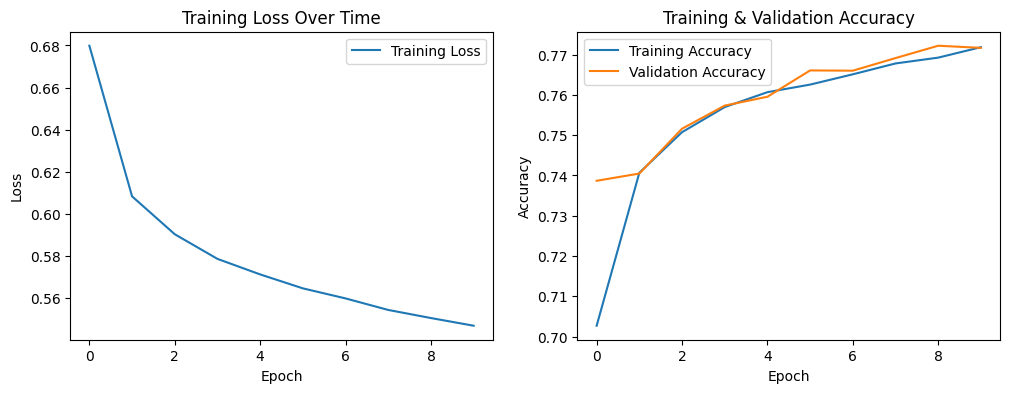

In [55]:
import matplotlib.pyplot as plt


# Plotting the metrics
plt.figure(figsize=(12, 4))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(training_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(training_accuracies, label='Training Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.show()

In [62]:
run_test('/content/models/model.pt','roberta')

Picking Robert-GRU Model


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Preprocessing Dataset...
1. Removing punctuations


100%|██████████| 13980/13980 [00:00<00:00, 47001.93it/s]


2. Converting text to lower case


100%|██████████| 13980/13980 [00:00<00:00, 668091.31it/s]


3. Removing Stop Words
Stopwords already downloaded.


100%|██████████| 13980/13980 [00:02<00:00, 5831.71it/s]


4. Converting to stars to sentiment


100%|██████████| 13980/13980 [00:00<00:00, 969741.18it/s]


5. Enconding sentiments to 0, 1, 2 (Positive, Negative, Neutral)
Preprocessing done!
13980


100%|██████████| 437/437 [02:06<00:00,  3.46it/s]

F1 Score: 0.8278720719793964
Test Accuracy: 0.82
Accuracy for class 0: 0.9109442060085837
Accuracy for class 1: 0.859513590844063
Accuracy for class 2: 0.8698855507868384


### Analysis:
As we can see above the max training and validation accuracy reached is 77%. However, the test dataset scores given above which are quite impressive compared to the validation accuracy during training.
Results:
- F1 score = 0.827
- Test Accuracy = 0.82

### Training Experiment 2: Finetuning
Gradual unfreezing of layers upto 5 layers of roberta Encoder
Following roberta model configuration is used:
1. Learning Rate = $3e^{-5}$
2. Max Sequence Length = 256
3. Epoch Size = Total of 12
4. Training Batch Size = 32
5. Validation Batch Size = 16
6. AdamW Optimizer
7. Categorical Cross Entropy Loss Function

In [104]:
training_accuracies, training_losses, validation_accuracies = run('roberta')

Preprocessing data...
Picking Robert-GRU Model


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Loss: 0.6920,Accuracy: 0.6979: 100%|██████████| 563/563 [01:27<00:00,  6.45Batch/s]


Epoch 1/2, Train Loss: 0.6920, Train Accuracy: 0.6979



100%|██████████| 125/125 [00:09<00:00, 13.19it/s]


Validation - Epoch: 0 Accuracy: 71.1%


Loss: 0.6173,Accuracy: 0.7368: 100%|██████████| 563/563 [01:27<00:00,  6.45Batch/s]


Epoch 2/2, Train Loss: 0.6173, Train Accuracy: 0.7368



100%|██████████| 125/125 [00:09<00:00, 13.20it/s]


Validation - Epoch: 1 Accuracy: 72.7%
Unfreezing last 1 layers of RoBERTa.


Loss: 0.6003,Accuracy: 0.7453: 100%|██████████| 563/563 [01:36<00:00,  5.82Batch/s]


Epoch 1/2, Train Loss: 0.6003, Train Accuracy: 0.7453



100%|██████████| 125/125 [00:09<00:00, 13.11it/s]


Validation - Epoch: 0 Accuracy: 73.25%


Loss: 0.5941,Accuracy: 0.7444: 100%|██████████| 563/563 [01:36<00:00,  5.83Batch/s]


Epoch 2/2, Train Loss: 0.5941, Train Accuracy: 0.7444



100%|██████████| 125/125 [00:09<00:00, 13.20it/s]


Validation - Epoch: 1 Accuracy: 73.2%
Unfreezing last 2 layers of RoBERTa.


Loss: 0.5878,Accuracy: 0.7486: 100%|██████████| 563/563 [01:49<00:00,  5.16Batch/s]


Epoch 1/2, Train Loss: 0.5878, Train Accuracy: 0.7486



100%|██████████| 125/125 [00:09<00:00, 13.24it/s]


Validation - Epoch: 0 Accuracy: 74.25%


Loss: 0.5712,Accuracy: 0.7593: 100%|██████████| 563/563 [01:49<00:00,  5.16Batch/s]


Epoch 2/2, Train Loss: 0.5712, Train Accuracy: 0.7593



100%|██████████| 125/125 [00:09<00:00, 13.24it/s]


Validation - Epoch: 1 Accuracy: 74.6%
Unfreezing last 3 layers of RoBERTa.


Loss: 0.5605,Accuracy: 0.7635: 100%|██████████| 563/563 [02:01<00:00,  4.64Batch/s]


Epoch 1/2, Train Loss: 0.5605, Train Accuracy: 0.7635



100%|██████████| 125/125 [00:09<00:00, 13.22it/s]


Validation - Epoch: 0 Accuracy: 75.2%


Loss: 0.5428,Accuracy: 0.7728: 100%|██████████| 563/563 [02:01<00:00,  4.64Batch/s]


Epoch 2/2, Train Loss: 0.5428, Train Accuracy: 0.7728



100%|██████████| 125/125 [00:09<00:00, 13.25it/s]


Validation - Epoch: 1 Accuracy: 75.44999999999999%
Unfreezing last 4 layers of RoBERTa.


Loss: 0.5372,Accuracy: 0.7741: 100%|██████████| 563/563 [02:13<00:00,  4.21Batch/s]


Epoch 1/2, Train Loss: 0.5372, Train Accuracy: 0.7741



100%|██████████| 125/125 [00:09<00:00, 13.24it/s]


Validation - Epoch: 0 Accuracy: 76.95%


Loss: 0.5188,Accuracy: 0.7841: 100%|██████████| 563/563 [02:13<00:00,  4.20Batch/s]


Epoch 2/2, Train Loss: 0.5188, Train Accuracy: 0.7841



100%|██████████| 125/125 [00:09<00:00, 13.19it/s]


Validation - Epoch: 1 Accuracy: 77.05%
Unfreezing last 5 layers of RoBERTa.


Loss: 0.5098,Accuracy: 0.7887: 100%|██████████| 563/563 [02:26<00:00,  3.85Batch/s]


Epoch 1/2, Train Loss: 0.5098, Train Accuracy: 0.7887



100%|██████████| 125/125 [00:09<00:00, 13.28it/s]


Validation - Epoch: 0 Accuracy: 77.35%


Loss: 0.4878,Accuracy: 0.8004: 100%|██████████| 563/563 [02:26<00:00,  3.85Batch/s]


Epoch 2/2, Train Loss: 0.4878, Train Accuracy: 0.8004



100%|██████████| 125/125 [00:09<00:00, 13.25it/s]


Validation - Epoch: 1 Accuracy: 78.60000000000001%


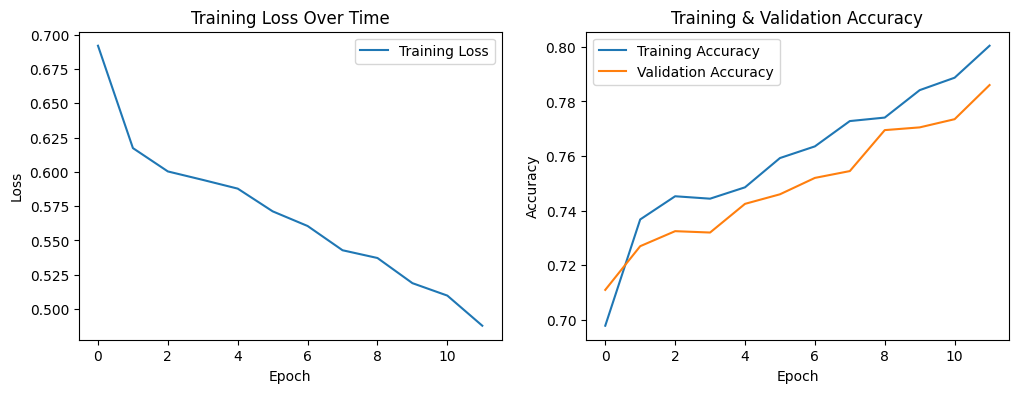

In [105]:
import matplotlib.pyplot as plt


# Plotting the metrics
plt.figure(figsize=(12, 4))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(training_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(training_accuracies, label='Training Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.show()

In [106]:
run_test('/content/models/model.pt','roberta')

Picking Robert-GRU Model


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Preprocessing Dataset...
1. Removing punctuations


100%|██████████| 13980/13980 [00:00<00:00, 47456.48it/s]


2. Converting text to lower case


100%|██████████| 13980/13980 [00:00<00:00, 501963.55it/s]


3. Removing Stop Words
Stopwords already downloaded.


100%|██████████| 13980/13980 [00:02<00:00, 5876.14it/s]


4. Converting to stars to sentiment


100%|██████████| 13980/13980 [00:00<00:00, 1042999.16it/s]


5. Enconding sentiments to 0, 1, 2 (Positive, Negative, Neutral)
Preprocessing done!
13980


100%|██████████| 437/437 [01:00<00:00,  7.27it/s]

F1 Score: 0.8283103641323982
Test Accuracy: 0.81
Accuracy for class 0: 0.9143776824034334
Accuracy for class 1: 0.8434191702432046
Accuracy for class 2: 0.8663805436337625


### Training Experiment 1: Training with Balanced Dataset
Following roberta model configuration is used:
1. Dataset used is balanced. Minority classes are augmented to a size of 50000 and majority class is downsampled to 50000.
2. Learning Rate = $3e^{-4}$ (when training with pretrained model freezed weights)
3. Learning Rate = $3e^{-5}$ (when training with pretrained model unfreezed weights)
4. Max Sequence Length = 256
5. Epoch Size = 2(when training with pretrained model freezed weights) + 8(when training with pretrained model unfreezed weights)
6. Training Batch Size = 32
7. Validation Batch Size = 16
8. AdamW Optimizer
9. Categorical Cross Entropy Loss Function

In [120]:
training_accuracies, training_losses, validation_accuracies = run('roberta')

Preprocessing data...
Picking Robert-GRU Model


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Loss: 0.5990,Accuracy: 0.7442: 100%|██████████| 4219/4219 [10:56<00:00,  6.43Batch/s]


Epoch 1/2, Train Loss: 0.5990, Train Accuracy: 0.7442



100%|██████████| 938/938 [01:09<00:00, 13.47it/s]


Validation - Epoch: 0 Accuracy: 78.02%


Loss: 0.5146,Accuracy: 0.7847: 100%|██████████| 4219/4219 [10:56<00:00,  6.42Batch/s]


Epoch 2/2, Train Loss: 0.5146, Train Accuracy: 0.7847



100%|██████████| 938/938 [01:09<00:00, 13.47it/s]


Validation - Epoch: 1 Accuracy: 80.52%
Unfreezing last 12 layers of RoBERTa.


Loss: 0.4206,Accuracy: 0.8276: 100%|██████████| 4219/4219 [29:23<00:00,  2.39Batch/s]


Epoch 1/2, Train Loss: 0.4206, Train Accuracy: 0.8276



100%|██████████| 938/938 [01:09<00:00, 13.45it/s]


Validation - Epoch: 0 Accuracy: 85.22666666666666%


Loss: 0.3678,Accuracy: 0.8508: 100%|██████████| 4219/4219 [29:06<00:00,  2.42Batch/s]


Epoch 2/2, Train Loss: 0.3678, Train Accuracy: 0.8508



100%|██████████| 938/938 [01:09<00:00, 13.51it/s]


Validation - Epoch: 1 Accuracy: 85.69333333333333%


Loss: 0.3556,Accuracy: 0.8552: 100%|██████████| 4219/4219 [29:09<00:00,  2.41Batch/s]


Epoch 3/2, Train Loss: 0.3556, Train Accuracy: 0.8552



100%|██████████| 938/938 [01:09<00:00, 13.49it/s]


Validation - Epoch: 2 Accuracy: 85.67333333333333%


Loss: 0.3482,Accuracy: 0.8583:  30%|██▉       | 1264/4219 [08:42<20:21,  2.42Batch/s]


KeyboardInterrupt: ignored

## Experiment 2: Training Without Balanced Dataset
Following roberta model configuration is used:
1. Learning Rate = $3e^{-4}$ (when training with pretrained model freezed weights)
2. Learning Rate = $3e^{-5}$ (when training with pretrained model unfreezed weights)
3. Max Sequence Length = 256
4. Epoch Size = 2(when training with pretrained model freezed weights) + 8(when training with pretrained model unfreezed weights)
5. Training Batch Size = 32
6. Validation Batch Size = 16
7. AdamW Optimizer
8. Categorical Cross Entropy Loss Function

In [116]:
training_accuracies, training_losses, validation_accuracies = run('roberta')

Preprocessing data...
Preprocessing Dataset...
1. Removing punctuations


100%|██████████| 174757/174757 [00:04<00:00, 43386.00it/s]


2. Converting text to lower case


100%|██████████| 174757/174757 [00:00<00:00, 506955.04it/s]


3. Removing Stop Words
Stopwords already downloaded.


100%|██████████| 174757/174757 [00:30<00:00, 5639.49it/s]


4. Converting to stars to sentiment


100%|██████████| 174757/174757 [00:00<00:00, 1017415.80it/s]


5. Enconding sentiments to 0, 1, 2 (Positive, Negative, Neutral)
Preprocessing done!
Picking Robert-GRU Model


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Loss: 0.4201,Accuracy: 0.8392: 100%|██████████| 4916/4916 [12:37<00:00,  6.49Batch/s]


Epoch 1/2, Train Loss: 0.4201, Train Accuracy: 0.8392



100%|██████████| 1093/1093 [01:20<00:00, 13.50it/s]


Validation - Epoch: 0 Accuracy: 85.88349736781872%


Loss: 0.3719,Accuracy: 0.8572: 100%|██████████| 4916/4916 [12:37<00:00,  6.49Batch/s]


Epoch 2/2, Train Loss: 0.3719, Train Accuracy: 0.8572



100%|██████████| 1093/1093 [01:21<00:00, 13.49it/s]


Validation - Epoch: 1 Accuracy: 87.04509040970474%
Unfreezing last 12 layers of RoBERTa.


Loss: 0.3177,Accuracy: 0.8782: 100%|██████████| 4916/4916 [33:51<00:00,  2.42Batch/s]


Epoch 1/2, Train Loss: 0.3177, Train Accuracy: 0.8782



100%|██████████| 1093/1093 [01:21<00:00, 13.47it/s]


Validation - Epoch: 0 Accuracy: 88.78461890592813%


Loss: 0.2811,Accuracy: 0.8926: 100%|██████████| 4916/4916 [33:52<00:00,  2.42Batch/s]


Epoch 2/2, Train Loss: 0.2811, Train Accuracy: 0.8926



100%|██████████| 1093/1093 [01:21<00:00, 13.47it/s]


Validation - Epoch: 1 Accuracy: 89.43121995880064%


Loss: 0.2718,Accuracy: 0.8964: 100%|██████████| 4916/4916 [33:51<00:00,  2.42Batch/s]


Epoch 3/2, Train Loss: 0.2718, Train Accuracy: 0.8964



100%|██████████| 1093/1093 [01:21<00:00, 13.46it/s]


Validation - Epoch: 2 Accuracy: 89.41977569237812%


Loss: 0.2715,Accuracy: 0.8961: 100%|██████████| 4916/4916 [33:51<00:00,  2.42Batch/s]


Epoch 4/2, Train Loss: 0.2715, Train Accuracy: 0.8961



100%|██████████| 1093/1093 [01:21<00:00, 13.36it/s]


Validation - Epoch: 3 Accuracy: 89.4369420920119%


Loss: 0.2707,Accuracy: 0.8965: 100%|██████████| 4916/4916 [33:52<00:00,  2.42Batch/s]


Epoch 5/2, Train Loss: 0.2707, Train Accuracy: 0.8965



100%|██████████| 1093/1093 [01:20<00:00, 13.52it/s]


Validation - Epoch: 4 Accuracy: 89.41977569237812%


Loss: 0.2714,Accuracy: 0.8957: 100%|██████████| 4916/4916 [33:51<00:00,  2.42Batch/s]


Epoch 6/2, Train Loss: 0.2714, Train Accuracy: 0.8957



100%|██████████| 1093/1093 [01:21<00:00, 13.49it/s]


Validation - Epoch: 5 Accuracy: 89.43121995880064%


Loss: 0.2711,Accuracy: 0.8962: 100%|██████████| 4916/4916 [33:51<00:00,  2.42Batch/s]


Epoch 7/2, Train Loss: 0.2711, Train Accuracy: 0.8962



100%|██████████| 1093/1093 [01:20<00:00, 13.54it/s]


Validation - Epoch: 6 Accuracy: 89.42549782558939%


Loss: 0.2720,Accuracy: 0.8963: 100%|██████████| 4916/4916 [33:51<00:00,  2.42Batch/s]


Epoch 8/2, Train Loss: 0.2720, Train Accuracy: 0.8963



100%|██████████| 1093/1093 [01:21<00:00, 13.45it/s]


Validation - Epoch: 7 Accuracy: 89.42549782558939%


## Training loss vs Epoch Graph and Training Accuracy vs Validation Accuracy Plot

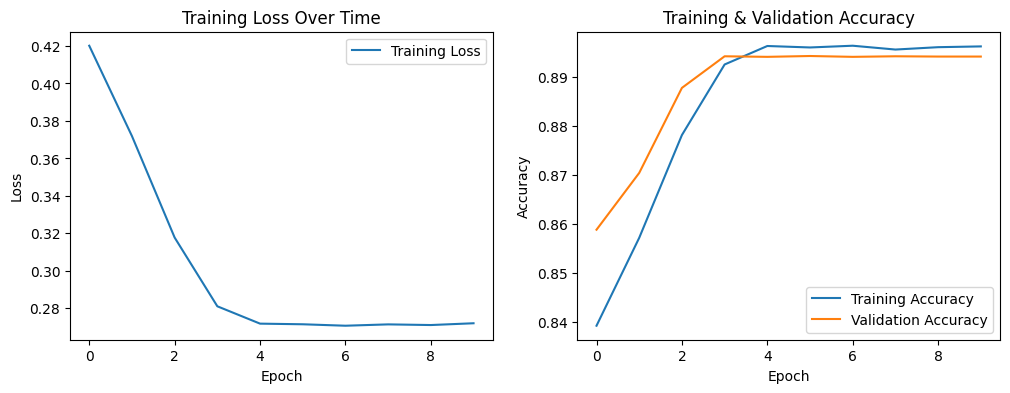

In [117]:
import matplotlib.pyplot as plt


# Plotting the metrics
plt.figure(figsize=(12, 4))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(training_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(training_accuracies, label='Training Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.show()

In [118]:
run_test('/content/drive/MyDrive/model_best.pt','roberta')

Picking Robert-GRU Model


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Preprocessing Dataset...
1. Removing punctuations


100%|██████████| 13980/13980 [00:00<00:00, 41296.13it/s]


2. Converting text to lower case


100%|██████████| 13980/13980 [00:00<00:00, 519365.54it/s]


3. Removing Stop Words
Stopwords already downloaded.


100%|██████████| 13980/13980 [00:02<00:00, 5490.89it/s]


4. Converting to stars to sentiment


100%|██████████| 13980/13980 [00:00<00:00, 992978.44it/s]


5. Enconding sentiments to 0, 1, 2 (Positive, Negative, Neutral)
Preprocessing done!
13980


100%|██████████| 437/437 [01:00<00:00,  7.23it/s]

F1 Score: 0.8834094356913508
Test Accuracy: 0.89
Accuracy for class 0: 0.9458512160228898
Accuracy for class 1: 0.9105150214592275
Accuracy for class 2: 0.9287553648068669


### Training Experiment 2: Gradual Unfreezing of Pretrained RoBERTa Layers
Gradual unfreezing of layers upto 5 layers of roberta Encoder
Following roberta model configuration is used:
1. Learning Rate = $3e^{-5}$
2. Max Sequence Length = 256
3. Epoch Size = Total of 12
4. Training Batch Size = 32
5. Validation Batch Size = 16
6. AdamW Optimizer
7. Categorical Cross Entropy Loss Function

In [108]:
training_accuracies, training_losses, validation_accuracies = run('roberta')

Preprocessing data...
Picking Robert-GRU Model


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Loss: 0.6935,Accuracy: 0.6978: 100%|██████████| 563/563 [01:27<00:00,  6.46Batch/s]


Epoch 1/2, Train Loss: 0.6935, Train Accuracy: 0.6978



100%|██████████| 125/125 [00:09<00:00, 13.18it/s]


Validation - Epoch: 0 Accuracy: 73.3%


Loss: 0.6221,Accuracy: 0.7351: 100%|██████████| 563/563 [01:26<00:00,  6.47Batch/s]


Epoch 2/2, Train Loss: 0.6221, Train Accuracy: 0.7351



100%|██████████| 125/125 [00:09<00:00, 13.18it/s]


Validation - Epoch: 1 Accuracy: 73.75%
Unfreezing last 1 layers of RoBERTa.


Loss: 0.6017,Accuracy: 0.7427: 100%|██████████| 563/563 [01:36<00:00,  5.82Batch/s]



Epoch 1/2, Train Loss: 0.6017, Train Accuracy: 0.7427


100%|██████████| 125/125 [00:09<00:00, 13.26it/s]


Validation - Epoch: 0 Accuracy: 74.05000000000001%


Loss: 0.5996,Accuracy: 0.7421: 100%|██████████| 563/563 [01:36<00:00,  5.83Batch/s]


Epoch 2/2, Train Loss: 0.5996, Train Accuracy: 0.7421



100%|██████████| 125/125 [00:09<00:00, 13.26it/s]


Validation - Epoch: 1 Accuracy: 73.8%
Unfreezing last 2 layers of RoBERTa.


Loss: 0.5902,Accuracy: 0.7516: 100%|██████████| 563/563 [01:48<00:00,  5.17Batch/s]


Epoch 1/2, Train Loss: 0.5902, Train Accuracy: 0.7516



100%|██████████| 125/125 [00:09<00:00, 13.25it/s]


Validation - Epoch: 0 Accuracy: 75.4%


Loss: 0.5773,Accuracy: 0.7569: 100%|██████████| 563/563 [01:48<00:00,  5.17Batch/s]


Epoch 2/2, Train Loss: 0.5773, Train Accuracy: 0.7569



100%|██████████| 125/125 [00:09<00:00, 13.27it/s]


Validation - Epoch: 1 Accuracy: 75.05%
Unfreezing last 3 layers of RoBERTa.


Loss: 0.5622,Accuracy: 0.7606: 100%|██████████| 563/563 [02:01<00:00,  4.64Batch/s]


Epoch 1/2, Train Loss: 0.5622, Train Accuracy: 0.7606



100%|██████████| 125/125 [00:09<00:00, 13.23it/s]


Validation - Epoch: 0 Accuracy: 76.7%


Loss: 0.5460,Accuracy: 0.7716: 100%|██████████| 563/563 [02:01<00:00,  4.63Batch/s]


Epoch 2/2, Train Loss: 0.5460, Train Accuracy: 0.7716



100%|██████████| 125/125 [00:09<00:00, 13.16it/s]


Validation - Epoch: 1 Accuracy: 76.9%
Unfreezing last 4 layers of RoBERTa.


Loss: 0.5358,Accuracy: 0.7769: 100%|██████████| 563/563 [02:13<00:00,  4.21Batch/s]


Epoch 1/2, Train Loss: 0.5358, Train Accuracy: 0.7769



100%|██████████| 125/125 [00:09<00:00, 13.23it/s]


Validation - Epoch: 0 Accuracy: 77.7%


Loss: 0.5176,Accuracy: 0.7834: 100%|██████████| 563/563 [02:13<00:00,  4.20Batch/s]


Epoch 2/2, Train Loss: 0.5176, Train Accuracy: 0.7834



100%|██████████| 125/125 [00:09<00:00, 13.20it/s]


Validation - Epoch: 1 Accuracy: 78.14999999999999%
Unfreezing last 5 layers of RoBERTa.


Loss: 0.5100,Accuracy: 0.7881: 100%|██████████| 563/563 [02:26<00:00,  3.85Batch/s]


Epoch 1/2, Train Loss: 0.5100, Train Accuracy: 0.7881



100%|██████████| 125/125 [00:09<00:00, 13.18it/s]


Validation - Epoch: 0 Accuracy: 79.0%


Loss: 0.4889,Accuracy: 0.7995: 100%|██████████| 563/563 [02:26<00:00,  3.85Batch/s]


Epoch 2/2, Train Loss: 0.4889, Train Accuracy: 0.7995



100%|██████████| 125/125 [00:09<00:00, 13.22it/s]


Validation - Epoch: 1 Accuracy: 79.85%


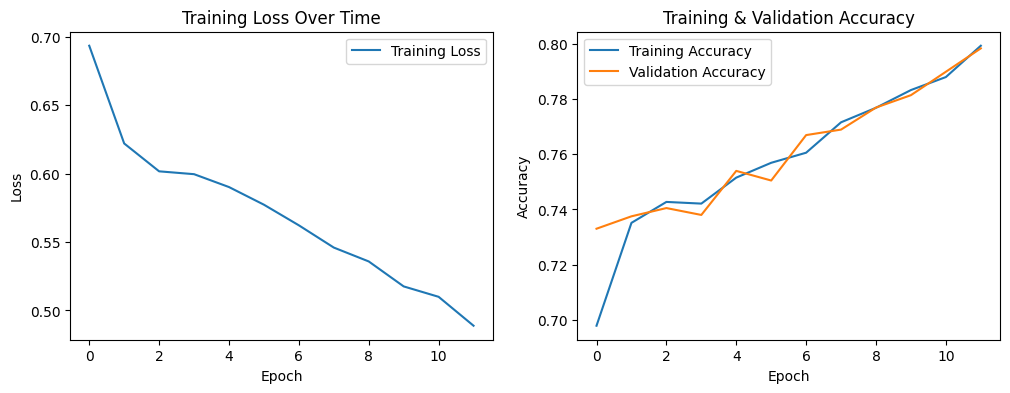

In [109]:
import matplotlib.pyplot as plt


# Plotting the metrics
plt.figure(figsize=(12, 4))

# Plot training loss
plt.subplot(1, 2, 1)
plt.plot(training_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.legend()

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(training_accuracies, label='Training Accuracy')
plt.plot(validation_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training & Validation Accuracy')
plt.legend()

plt.show()

In [110]:
run_test('/content/models/model.pt','roberta')

Picking Robert-GRU Model


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Preprocessing Dataset...
1. Removing punctuations


100%|██████████| 13980/13980 [00:00<00:00, 44967.92it/s]


2. Converting text to lower case


100%|██████████| 13980/13980 [00:00<00:00, 476578.97it/s]


3. Removing Stop Words
Stopwords already downloaded.


100%|██████████| 13980/13980 [00:02<00:00, 5706.42it/s]


4. Converting to stars to sentiment


100%|██████████| 13980/13980 [00:00<00:00, 930824.68it/s]


5. Enconding sentiments to 0, 1, 2 (Positive, Negative, Neutral)
Preprocessing done!
13980


100%|██████████| 437/437 [01:00<00:00,  7.26it/s]

F1 Score: 0.8273615235834577
Test Accuracy: 0.81
Accuracy for class 0: 0.9167381974248927
Accuracy for class 1: 0.8382689556509298
Accuracy for class 2: 0.8640200286123033


# Result and Experiment Analysis

## With Dataset Augmentation and Balancing
In the first experiment, the dataset was augmented by downsampling the positive class to match the
average size of the other classes. The results were as follows:
- F1 Score: 0.885
- Test Accuracy: 0.88
- AUC Scores: Negative - 0.985, Neutral - 0.897, Positive - 0.975
These results indicate a balanced and effective model performance across all classes, underscoring
the benefits of dataset augmentation and balancing.

Picking Robert-GRU Model


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Preprocessing Dataset...
1. Removing punctuations


100%|██████████| 13980/13980 [00:00<00:00, 48226.65it/s]


2. Converting text to lower case


100%|██████████| 13980/13980 [00:00<00:00, 569235.41it/s]


3. Removing Stop Words
Stopwords already downloaded.


100%|██████████| 13980/13980 [00:02<00:00, 5836.12it/s]


4. Converting to stars to sentiment


100%|██████████| 13980/13980 [00:00<00:00, 898283.75it/s]


5. Enconding sentiments to 0, 1, 2 (Positive, Negative, Neutral)
Preprocessing done!
13980


100%|██████████| 437/437 [01:00<00:00,  7.26it/s]


F1 Score: 0.8850373937040122
Test Accuracy: 0.88
AUC Scores: {'Class 0 AUC': 0.9848479321635488, 'Class 1 AUC': 0.8969745524384081, 'Class 2 AUC': 0.975101430843007}


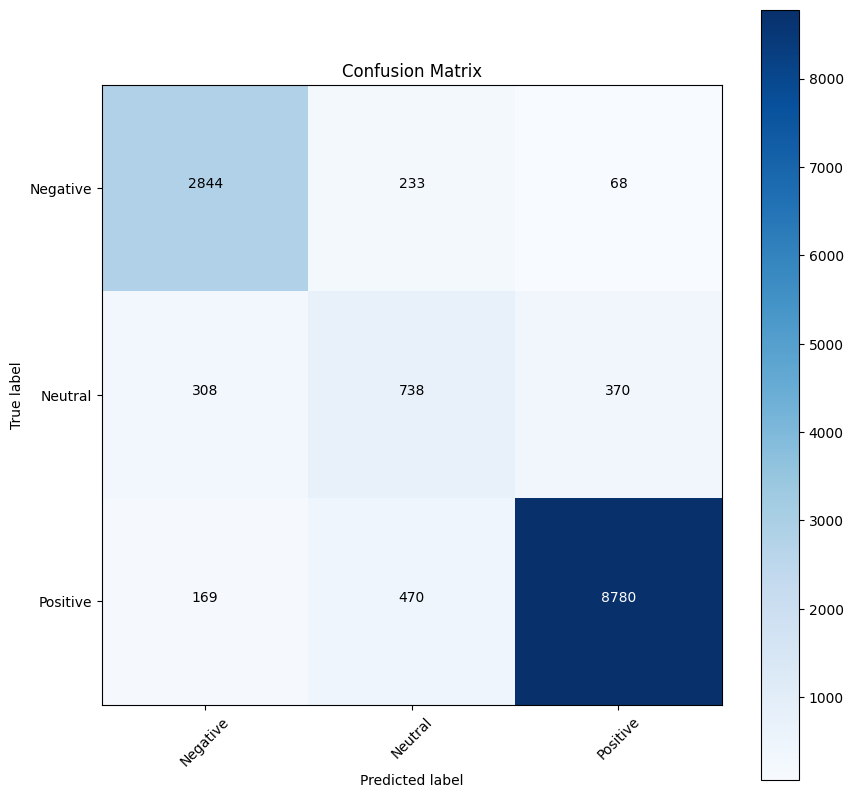

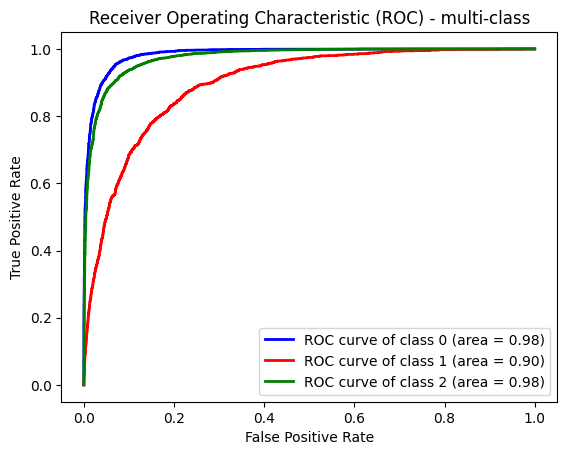

In [148]:
run_test('/content/models/model.pt','roberta')

# Experminent 2 Analysis: Without Dataset Augmentation and Balancing
The second experiment, conducted without dataset augmentation and balancing, yielded these results:
- F1 Score: 0.883
- Test Accuracy: 0.89
- AUC Scores: Negative - 0.986, Neutral - 0.902, Positive - 0.977

Despite the absence of data balancing, the model achieved a slightly higher test accuracy. However,
the F1 score was marginally lower than in the balanced dataset experiment. A key factor in this
performance is the imbalance in the test dataset, which mirrors the training dataset’s skew towards
the positive class.


Picking Robert-GRU Model


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Preprocessing Dataset...
1. Removing punctuations


100%|██████████| 13980/13980 [00:00<00:00, 47254.77it/s]


2. Converting text to lower case


100%|██████████| 13980/13980 [00:00<00:00, 402277.49it/s]


3. Removing Stop Words
Stopwords already downloaded.


100%|██████████| 13980/13980 [00:02<00:00, 5501.24it/s]


4. Converting to stars to sentiment


100%|██████████| 13980/13980 [00:00<00:00, 902778.55it/s]


5. Enconding sentiments to 0, 1, 2 (Positive, Negative, Neutral)
Preprocessing done!
13980


100%|██████████| 437/437 [01:00<00:00,  7.26it/s]


F1 Score: 0.8834094356913508
Test Accuracy: 0.89
AUC Scores: {'Class 0 AUC': 0.9855779311437717, 'Class 1 AUC': 0.9018830930269787, 'Class 2 AUC': 0.9769842494862495}


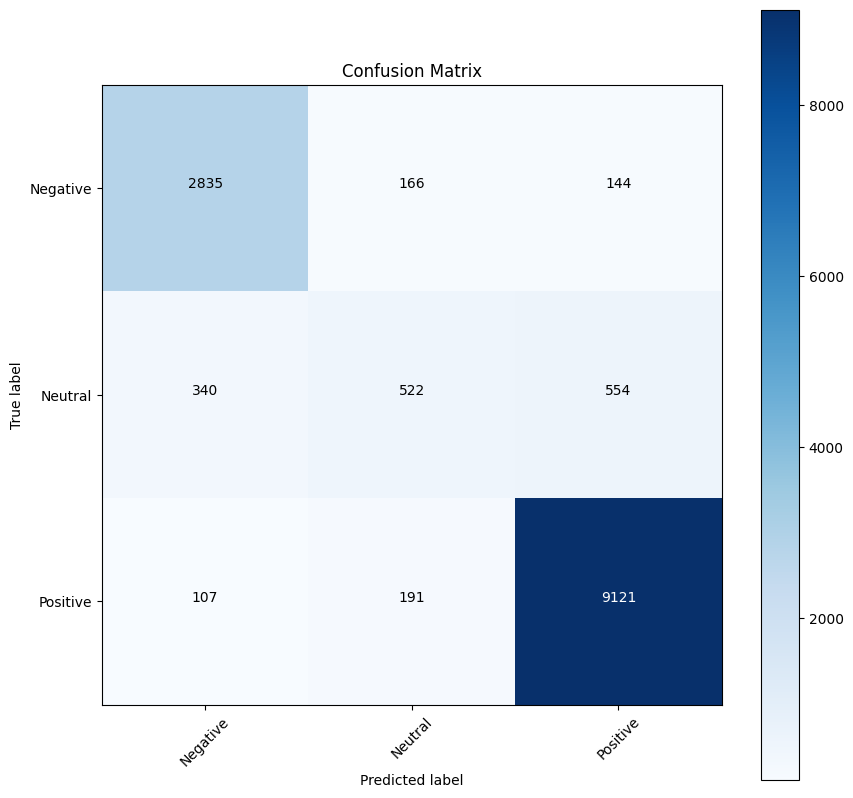

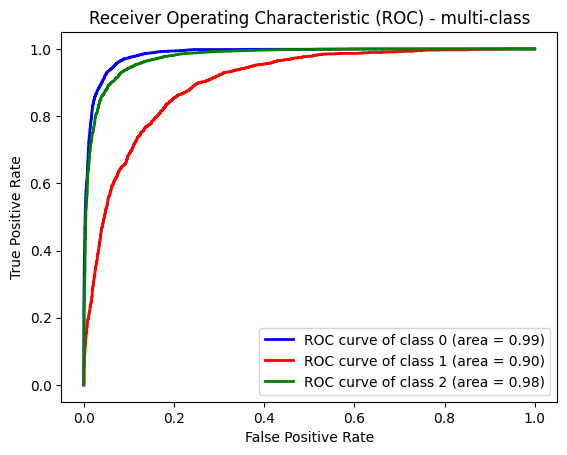

In [153]:
run_test('/content/drive/MyDrive/Models/model_best.pt','roberta')

## Experiment 3 Analysis: Gradual Unfreezing of Pretrained RoBERTa Layers
Another experiment involved gradually unfreezing the pretrained RoBERTa layers:
- F1 Score: 0.827
- Test Accuracy: 0.81
- AUC Scores: Negative - 0.967, Neutral - 0.835, Positive - 0.952

This strategy led to lower performance metrics, suggesting that gradual unfreezing did not favorably
impact the model’s accuracy for this specific task

Picking Robert-GRU Model


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Preprocessing Dataset...
1. Removing punctuations


100%|██████████| 13980/13980 [00:00<00:00, 43017.37it/s]


2. Converting text to lower case


100%|██████████| 13980/13980 [00:00<00:00, 651117.32it/s]


3. Removing Stop Words
Stopwords already downloaded.


100%|██████████| 13980/13980 [00:02<00:00, 5364.55it/s]


4. Converting to stars to sentiment


100%|██████████| 13980/13980 [00:00<00:00, 871695.93it/s]


5. Enconding sentiments to 0, 1, 2 (Positive, Negative, Neutral)
Preprocessing done!
13980


100%|██████████| 437/437 [00:59<00:00,  7.29it/s]


F1 Score: 0.8273615235834577
Test Accuracy: 0.81
AUC Scores: {'Class 0 AUC': 0.9672681492806904, 'Class 1 AUC': 0.83450577675072, 'Class 2 AUC': 0.9517104713473508}


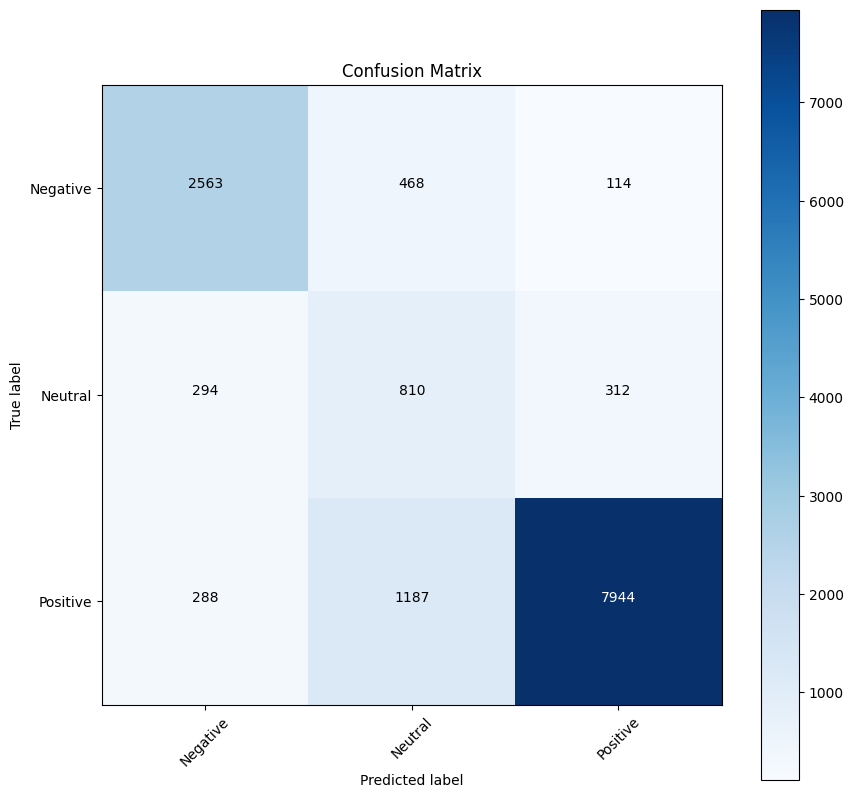

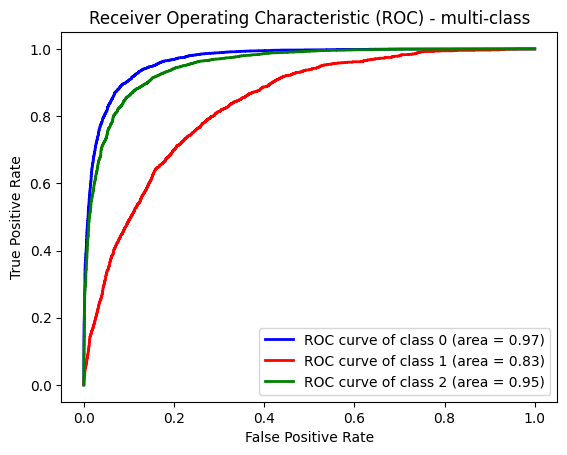

In [150]:
run_test('/content/drive/MyDrive/Models/model_v3_gradual_unfreezing.pt','roberta')